In [1]:
import tensorflow as tf
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=25

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\Deep Learning & ML\pneumonia_detection\training\chest_xray",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [10]:
len(dataset)

183

In [17]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy().min())
    print(image_batch[0].numpy().max())

0.0
255.0


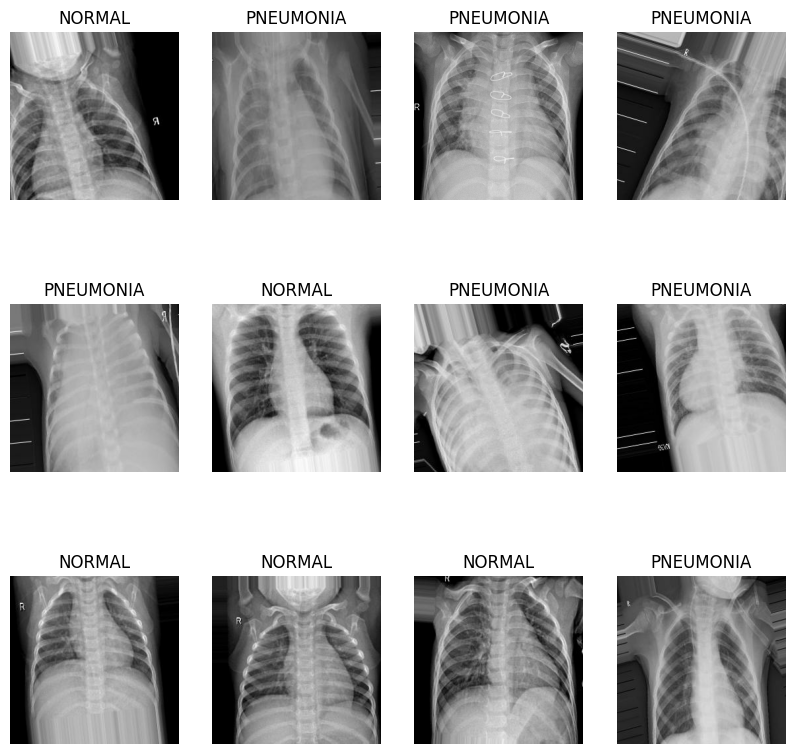

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):

    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [15]:
train_size = 0.8
len(dataset)*train_size

244.8

In [17]:
train_ds = dataset.take(244)
len(train_ds)

244

In [18]:
test_ds = dataset.skip(244)
len(test_ds)

62

In [19]:
val_size = 0.1
len(dataset)*val_size

30.6

In [20]:
val_ds = test_ds.take(30)
len(val_ds)

30

In [21]:
test_ds = test_ds.skip(30)
len(test_ds)

32

In [11]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [24]:
len(val_ds)

30

In [25]:
len(test_ds)

32

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [39]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    r"D:\Deep Learning & ML\pneumonia_detection\chest_xray_original\train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 5216 images belonging to 2 classes.


In [40]:
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        r"D:\Deep Learning & ML\pneumonia_detection\chest_xray_original\val",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 640 images belonging to 2 classes.


In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=2

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 30, 30, 64)       

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=5216 // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=640 // BATCH_SIZE
)

In [48]:
model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/25
163/163 [==============================] - 233s 1s/step - loss: 0.2363 - accuracy: 0.8997 - val_loss: 0.3638 - val_accuracy: 0.8469
Epoch 2/25
163/163 [==============================] - 237s 1s/step - loss: 0.2365 - accuracy: 0.9041 - val_loss: 0.3120 - val_accuracy: 0.8734
Epoch 3/25
163/163 [==============================] - 276s 2s/step - loss: 0.2162 - accuracy: 0.9105 - val_loss: 0.2933 - val_accuracy: 0.8719
Epoch 4/25
163/163 [==============================] - 229s 1s/step - loss: 0.2031 - accuracy: 0.9133 - val_loss: 0.3254 - val_accuracy: 0.8484
Epoch 5/25
163/163 [==============================] - 229s 1s/step - loss: 0.1957 - accuracy: 0.9185 - val_loss: 0.2659 - val_accuracy: 0.9031
Epoch 6/25
163/163 [==============================] - 241s 1s/step - loss: 0.1949 - accuracy: 0.9199 - val_loss: 0.3366 - val_accuracy: 0.8562
Epoch 7/25
163/163 [==============================] - 246s 2s/step - loss: 0.1904 - accuracy: 0.9216 - val_loss: 0.3994 - val_accuracy: 0.8297

In [59]:
model_version=1
model.save(f"D:\Deep Learning & ML\pneumonia_detection\model_updated\{model_version}")

INFO:tensorflow:Assets written to: D:\Deep Learning & ML\pneumonia_detection\model_updated\1\assets


INFO:tensorflow:Assets written to: D:\Deep Learning & ML\pneumonia_detection\model_updated\1\assets


In [53]:
MODEL = tf.keras.models.load_model(r"D:\Deep Learning & ML\pneumonia_detection\model_updated\1")

In [56]:
import numpy as np
import cv2

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    resized_image = cv2.resize(img_array, (256, 256))
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions =model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [57]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(MODEL, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

        plt.axis("off")

NameError: name 'test_ds' is not defined

<Figure size 1500x1500 with 0 Axes>

In [ ]:
MODEL.predict()